#Project Name: Molecular Classification of Cancer by Gene Expression Monitoring
* Author: Nguyen Thi Thu Hang
* Dataset: Gene expression dataset (Golub et al.)



##About [Dataset](https://https://www.kaggle.com/datasets/crawford/gene-expression?select=data_set_ALL_AML_train.csv) 
This dataset comes from a proof-of-concept study published in 1999 by Golub et al. It showed how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

Golub et al "Molecular Classification of Cancer: Class Discovery and Class
Prediction by Gene Expression Monitoring"

There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.


## Set Up

In [ ]:
!git clone https://github.com/NT-ThuHang/Cancer-Classification-using-Gene-Expression
%cd Cancer-Classification-using-Gene-Expression

Cloning into 'Cancer-Classification-using-Gene-Expression'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.
/content/Cancer-Classification-using-Gene-Expression


##Import library

In [64]:
import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc

In [ ]:
np.random.seed(42)

##Load Dataset

In [ ]:
train_df = pd.read_csv("./Dataset/data_set_ALL_AML_train.csv")
test_df = pd.read_csv("./Dataset/data_set_ALL_AML_independent.csv")
patient_number = pd.read_csv("./Dataset/actual.csv")
patient_number.columns = ["index","cancer_type"]

In [ ]:
print("Shape of train_df ", train_df.shape)
train_df.head()

Shape of train_df  (7129, 78)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
print("Shape of test_df ", test_df.shape)
test_df.head()

Shape of test_df  (7129, 70)


,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [ ]:
print("Shape of patient_number ", patient_number.shape)
patient_number.head()

Shape of patient_number  (72, 2)


,index,cancer_type
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [ ]:
#Delete all of "call" columns and two columns ["Gene Description","Gene Accession Number"]
column_name = [col for col in train_df.columns if "call" not in col]
train_df = train_df[column_name]
train_df = train_df.drop(["Gene Description","Gene Accession Number"], axis=1)
#transpose matrix
train_df = train_df.T

#labeling
train_df = train_df.reset_index()
train_df["index"] = pd.to_numeric(train_df["index"])
train_df = train_df.sort_values("index")

train_df = pd.merge(train_df, patient_number, on="index", how = "inner")
train_df.loc[train_df.cancer_type == "ALL", "cancer_type"] = 0
train_df.loc[train_df.cancer_type == "AML", "cancer_type"] = 1
#shuffle row
train_df = train_df.sample(frac=1, random_state = 0).drop(["index"], axis=1)
print("Size of training data", train_df.shape)
train_df.head()

Size of training data (38, 7130)


,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,cancer_type
22,-74,-321,-11,-36,-317,-499,-138,-119,115,-17,...,1058,140,176,-22,617,336,9,243,36,0
29,-318,-192,-95,312,-139,-344,324,-237,105,167,...,737,63,472,33,737,227,-9,371,-31,1
16,-476,-213,-18,301,-403,-394,-42,-144,98,173,...,1215,127,255,50,1701,1109,61,526,-83,0
15,-117,-219,-50,257,-218,-402,228,-147,65,67,...,631,-26,455,-62,736,445,42,246,-43,0
11,-67,-93,84,25,-179,-323,-135,-127,-2,-66,...,224,60,194,-10,291,41,8,-2,-80,0


In [ ]:
#Delete all of "call" columns and two columns ["Gene Description","Gene Accession Number"]
column_name = [col for col in test_df.columns if "call" not in col]
test_df = test_df[column_name]
test_df = test_df.drop(["Gene Description","Gene Accession Number"], axis=1)
#transpose matrix
test_df = test_df.T

#labeling
test_df = test_df.reset_index()
test_df.head()
test_df["index"] = pd.to_numeric(test_df["index"])
test_df = test_df.sort_values("index")

test_df = pd.merge(test_df, patient_number, on="index", how = "inner")
test_df.loc[test_df.cancer_type == "ALL", "cancer_type"] = 0
test_df.loc[test_df.cancer_type == "AML", "cancer_type"] = 1
#shuffle row
test_df = test_df.sample(frac=1, random_state = 0).drop(["index"], axis=1)
print("Size of testing data", test_df.shape)
test_df.head()


Size of testing data (34, 7130)


,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,cancer_type
11,-118,-142,212,314,-401,-452,-336,-310,177,-131,...,690,-8,331,-62,882,264,73,315,7,1
20,-12,-172,12,172,-137,-205,358,-104,-25,147,...,922,53,302,-78,673,208,-68,226,78,0
25,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,1141,-121,197,-108,466,349,0,284,-73,1
17,-95,-118,59,270,-229,-383,172,-187,185,157,...,700,-61,381,-105,1068,412,-43,702,18,0
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,383,46,104,15,245,164,84,100,-18,0


##Exploratory data analysis (EDA)

###Check the balance of training dataset

In [ ]:
train_df["cancer_type"].value_counts()

0    27
1    11
Name: cancer_type, dtype: int64

Text(0.5, 1.0, 'Class Distributions \n ( AML ||  ALL)')

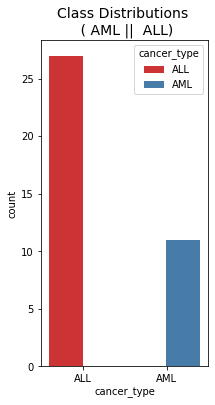

In [ ]:
df = pd.DataFrame()
df["cancer_type"] = train_df["cancer_type"]
df.loc[df.cancer_type == 0, "cancer_type"] = "ALL"
df.loc[df.cancer_type == 1, "cancer_type"] = "AML"


plt.figure(figsize=(3,6))
colors = ["AML", "ALL"]
sns.countplot(x = 'cancer_type', hue = "cancer_type", data = df, palette = "Set1")
plt.title('Class Distributions \n ( AML ||  ALL)', fontsize=14)

###Distribution of the random sample before standardizing

In [157]:
sample = train_df.iloc[:,:-1].sample(n=100, axis=1)
sample.describe().round()

,494,2264,4414,6368,2848,5353,4669,4366,3621,2553,...,937,3181,3935,6179,679,6387,826,3058,701,883
count,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0
mean,153.0,507.0,88.0,2517.0,1103.0,-625.0,100.0,248.0,359.0,129.0,...,-168.0,437.0,221.0,572.0,6.0,6595.0,-416.0,543.0,174.0,-249.0
std,56.0,207.0,90.0,1144.0,341.0,145.0,53.0,112.0,257.0,60.0,...,126.0,395.0,95.0,1259.0,34.0,3179.0,245.0,297.0,74.0,87.0
min,38.0,148.0,-167.0,687.0,314.0,-941.0,16.0,102.0,-142.0,21.0,...,-663.0,36.0,51.0,-346.0,-72.0,1821.0,-893.0,-142.0,28.0,-417.0
25%,123.0,328.0,53.0,1815.0,910.0,-710.0,68.0,175.0,176.0,86.0,...,-208.0,166.0,156.0,-111.0,-22.0,4404.0,-583.0,348.0,133.0,-290.0
50%,152.0,454.0,92.0,2387.0,1066.0,-634.0,102.0,231.0,363.0,131.0,...,-145.0,337.0,208.0,2.0,10.0,5978.0,-393.0,507.0,174.0,-250.0
75%,190.0,692.0,130.0,2942.0,1286.0,-524.0,130.0,276.0,561.0,173.0,...,-88.0,535.0,276.0,545.0,34.0,8290.0,-304.0,777.0,208.0,-175.0
max,277.0,864.0,339.0,6326.0,2015.0,-333.0,287.0,632.0,872.0,293.0,...,-1.0,1938.0,408.0,4303.0,68.0,14383.0,88.0,1133.0,392.0,-96.0


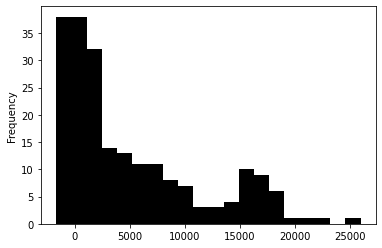

In [159]:
sample.plot(kind="hist", legend=None, bins=20, color='k')

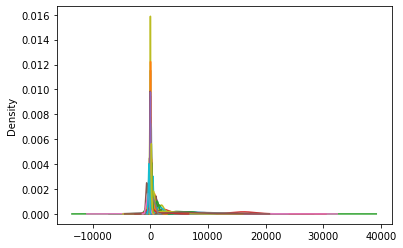

In [160]:
sample.plot(kind="kde", legend=None)

##Preprocessing 

In [ ]:
X_train = train_df.iloc[:,:-1].reset_index(drop=True)
y_train = train_df.iloc[:,-1].reset_index(drop=True).astype("int")

X_test = test_df.iloc[:,:-1].reset_index(drop=True)
y_test = test_df.iloc[:,-1].reset_index(drop=True).astype("int")

In [ ]:
X_train.shape

(38, 7129)

###StandardScaler

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)


###Distribution of the random sample after standardizing

In [162]:
sample = pd.DataFrame(X_train_scl).sample(n=100, axis=1)
sample.describe().round()

,3698,6253,495,3731,801,1538,1044,1756,223,1296,...,4839,2484,3270,6406,3342,1873,2482,384,943,4117
count,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0
mean,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-3.0,-2.0,...,-2.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-1.0,-3.0,-2.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
75%,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
max,3.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,2.0,3.0,3.0,4.0,2.0,3.0


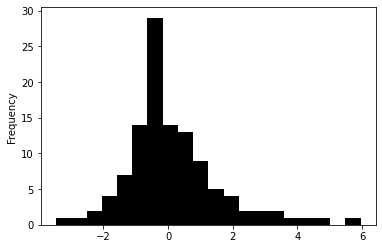

In [163]:
sample.plot(kind="hist", legend=None, bins=20, color='k')

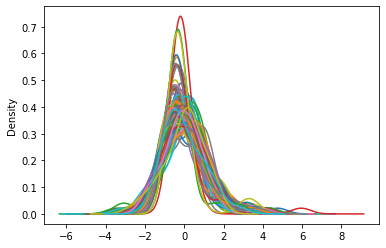

In [164]:
sample.plot(kind="kde", legend=None);

###PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)

#calculate remaining dimentions
total = sum(pca.explained_variance_)
current_variance = 0
i = 0
while current_variance/total < 0.90:
  current_variance += pca.explained_variance_[i]
  i += 1
#PCA
pca = PCA(n_components = i)
X_train_pca = pca.fit_transform(X_train_scl)
X_test_pca = pca.fit_transform(X_test_scl)

In [ ]:
X_train_pca.shape

(38, 22)

### Explore distribution of data through pca data 

[0.14987793 0.11977811 0.06600568]


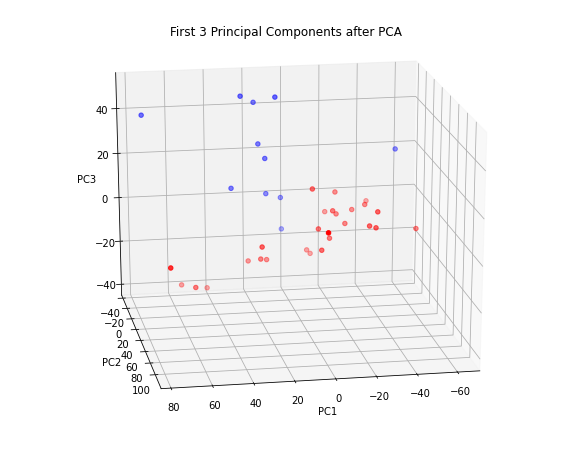

In [ ]:
#Let's do a pca first 
pca = PCA(n_components=3)
pca.fit_transform(X_train_scl)
print(pca.explained_variance_ratio_) # Small variance explained

PCA_df = pd.DataFrame(data = pca.fit_transform(X_train_scl), 
                           columns = ['pc1', 'pc2', 'pc3'])

train_target= df.iloc[:,-1]
PCA_df = pd.concat([PCA_df, train_target], axis = 1)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
colors = {'ALL':'red', 'AML':'blue'}
ax.scatter(PCA_df.pc1, PCA_df.pc2, PCA_df.pc3, 
           c = train_target.apply(lambda x: colors[x]))
plt.title('First 3 Principal Components after PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(20, 80)
plt.tight_layout
plt.show()

##Classification

In [65]:
ROC_results = dict()
PR_results = dict()

###Using SVM Methods

In [61]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

#### Original

In [67]:
# Grid Search
# Parameter Grid
param_grid_SVM_non_pca = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.05,0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]} 
# Make grid search classifier
clf_grid_SVM_non_pca = GridSearchCV(svm.SVC(probability=True,random_state=0), param_grid_SVM_non_pca, cv=10, verbose=1)

# Train the classifier
clf_grid_SVM_non_pca.fit(X_train_scl, y_train)

# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid_SVM_non_pca.best_params_)
print("Best Estimators:\n", clf_grid_SVM_non_pca.best_estimator_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best Parameters:
 {'C': 0.05, 'gamma': 1, 'kernel': 'linear'}
Best Estimators:
 SVC(C=0.05, gamma=1, kernel='linear', probability=True, random_state=0)


In [70]:
model_svm_with_non_pca_data = svm.SVC(**clf_grid_SVM_non_pca.best_params_, probability=True, random_state=0)
model_svm_with_non_pca_data.fit(X_train_scl,y_train)
pred = model_svm_with_non_pca_data.predict(X_test_scl)
pred = pred.tolist()
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.7941176470588235


In [86]:
probas = model_svm_with_non_pca_data.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["SVM"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["SVM"] = (precision, recall, AUCPR)

In [87]:
confusion_matrix(y_test, pred)

array([[20,  0],
       [ 7,  7]])

####PCA

In [91]:
# Grid Search
# Parameter Grid
param_grid_SVM_pca = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.05,0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]} 
# Make grid search classifier
clf_grid_SVM_pca = GridSearchCV(svm.SVC(probability=True,random_state=0), param_grid_SVM_pca, refit=True, verbose=1)

# Train the classifier
clf_grid_SVM_pca.fit(X_train_pca, y_train)

# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid_SVM_pca.best_params_)
print("Best Estimators:\n", clf_grid_SVM_pca.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters:
 {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best Estimators:
 SVC(C=10, gamma=0.001, kernel='sigmoid', probability=True, random_state=0)


In [92]:
model_svm_with_pca_data  = svm.SVC(**clf_grid_SVM_pca.best_params_, probability=True, random_state=0)
model_svm_with_pca_data .fit(X_train_pca,y_train)
pred = model_svm_with_pca_data .predict(X_test_pca)
pred = pred.tolist()
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.6176470588235294


In [94]:
probas = model_svm_with_pca_data.predict_proba(X_test_pca)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["SVM_PCA"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["SVM_PCA"] = (precision, recall, AUCPR)

In [95]:
confusion_matrix(y_test, pred)

array([[16,  4],
       [ 9,  5]])

###Using Kmeans Method

In [97]:
from sklearn.cluster import KMeans


####Original

In [98]:
model_KMeans_with_non_pca_data = KMeans(n_clusters=2, random_state=0)
model_KMeans_with_non_pca_data.fit_transform(X_train_scl)
pred = model_KMeans_with_non_pca_data.predict(X_test_scl)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.2647058823529412


In [100]:
confusion_matrix(y_test, pred)

array([[ 4, 16],
       [ 9,  5]])

####PCA

In [101]:
model_KMeans_with_pca_data = KMeans(n_clusters=2, random_state=0)
model_KMeans_with_pca_data.fit_transform(X_train_pca)
pred = model_KMeans_with_pca_data.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.7352941176470589


In [102]:
confusion_matrix(y_test, pred)

array([[16,  4],
       [ 5,  9]])

###Using Random Forest Method




In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }


# Create the GridSearchCV object
model_Random_Forest_data = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
model_Random_Forest_data.fit(X_train, y_train)
print("Best Parameters:\n", model_Random_Forest_data.best_params_)
print("Best Estimators:\n", model_Random_Forest_data.best_estimator_)

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 70}
Best Estimators:
 RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70, random_state=0)


In [110]:
# Get the best model
model_Radom_Forest_data_best = model_Random_Forest_data.best_estimator_

# Make predictions using the optimised parameters
pred = model_Radom_Forest_data_best.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.9117647058823529


In [111]:
probas = model_Radom_Forest_data_best.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["Random_Forest"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["Random_Forest"] = (precision, recall, AUCPR)

In [112]:
confusion_matrix(y_test, pred)

array([[18,  2],
       [ 1, 13]])

###Using GradientBoostingClassifier

In [114]:
from sklearn.ensemble import GradientBoostingClassifier 

####Original

In [115]:
model_GradientBoostingClassifier_non_pca_data = GradientBoostingClassifier(max_depth=5, loss='exponential', n_estimators=50, learning_rate=0.8, random_state=0)
model_GradientBoostingClassifier_non_pca_data.fit(X_train_scl, y_train)
pred = model_GradientBoostingClassifier_non_pca_data.predict(X_test_scl)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.9117647058823529


In [116]:
probas = model_GradientBoostingClassifier_non_pca_data.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["Gradient_Boosting_Classifier"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["Gradient_Boosting_Classifier"] = (precision, recall, AUCPR)

In [117]:
confusion_matrix(y_test, pred)

array([[18,  2],
       [ 1, 13]])

####PCA

In [118]:
model_GradientBoostingClassifier_pca_data= GradientBoostingClassifier(max_depth=5, loss='exponential', n_estimators=50, learning_rate=0.8, random_state=0)
model_GradientBoostingClassifier_pca_data.fit(X_train_pca, y_train)
pred = model_GradientBoostingClassifier_pca_data.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.5


In [119]:
probas = model_GradientBoostingClassifier_pca_data.predict_proba(X_test_pca)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["Gradient_Boosting_Classifier_PCA"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["Gradient_Boosting_Classifier_PCA"] = (precision, recall, AUCPR)

In [120]:
confusion_matrix(y_test, pred)

array([[13,  7],
       [10,  4]])

###Using XGBoost

In [122]:
import xgboost 

####Original

In [123]:
model_XGBoost_non_pca_data=xgboost.XGBClassifier(random_state=0)
model_XGBoost_non_pca_data.fit(X_train_scl, y_train)
pred = model_XGBoost_non_pca_data.predict(X_test_scl)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.9117647058823529


In [124]:
probas = model_XGBoost_non_pca_data.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["XGBoost"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["XGBoost"] = (precision, recall, AUCPR)

In [125]:
confusion_matrix(y_test, pred)

array([[18,  2],
       [ 1, 13]])

####PCA


In [126]:
model_XGBoost_pca_data=xgboost.XGBClassifier(random_state=0)
model_XGBoost_pca_data.fit(X_train_pca, y_train)
pred = model_XGBoost_pca_data.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.5


In [127]:
probas = model_XGBoost_pca_data.predict_proba(X_test_pca)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["XGBoost_PCA"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["XGBoost_PCA"] = (precision, recall, AUCPR)

In [128]:
confusion_matrix(y_test, pred)

array([[15,  5],
       [12,  2]])

###Using Neural Network

In [129]:
from tensorflow import keras

####Original

In [130]:
NN_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=X_train_scl[1].shape),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [131]:
NN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy']
)

In [132]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

In [133]:
train_history = NN_model.fit(
    X_train_scl, y_train,
    validation_data=(X_test_scl, y_test),
    batch_size = 8,
    epochs = 500,
    callbacks=[early_stopping]
)

Epoch 1/500
5/5 [==============================] - 1s 53ms/step - loss: 0.4461 - binary_accuracy: 0.7895 - val_loss: 0.5268 - val_binary_accuracy: 0.7059
Epoch 2/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0104 - binary_accuracy: 1.0000 - val_loss: 0.8113 - val_binary_accuracy: 0.7059
Epoch 3/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0018 - binary_accuracy: 1.0000 - val_loss: 1.0365 - val_binary_accuracy: 0.7353
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 5.1295e-04 - binary_accuracy: 1.0000 - val_loss: 1.1822 - val_binary_accuracy: 0.7059
Epoch 5/500
5/5 [==============================] - 0s 13ms/step - loss: 2.1156e-04 - binary_accuracy: 1.0000 - val_loss: 1.2763 - val_binary_accuracy: 0.7059
Epoch 6/500
5/5 [==============================] - 0s 15ms/step - loss: 1.2271e-04 - binary_accuracy: 1.0000 - val_loss: 1.3361 - val_binary_accuracy: 0.7059


In [134]:
pred = np.asarray(NN_model.predict(X_test_scl)>0.5, dtype="int")
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.7058823529411765


In [135]:
confusion_matrix(y_test, pred)

array([[17,  3],
       [ 7,  7]])

##Visualize Results

In [136]:
names = ['SVM',
         'SVM_PCA', 
         'Random_Forest', 
         'Gradient_Boosting_Classifier', 
         'Gradient_Boosting_Classifier_PCA', 
         'XGBoost',
         'XGBoost_PCA'
        ]

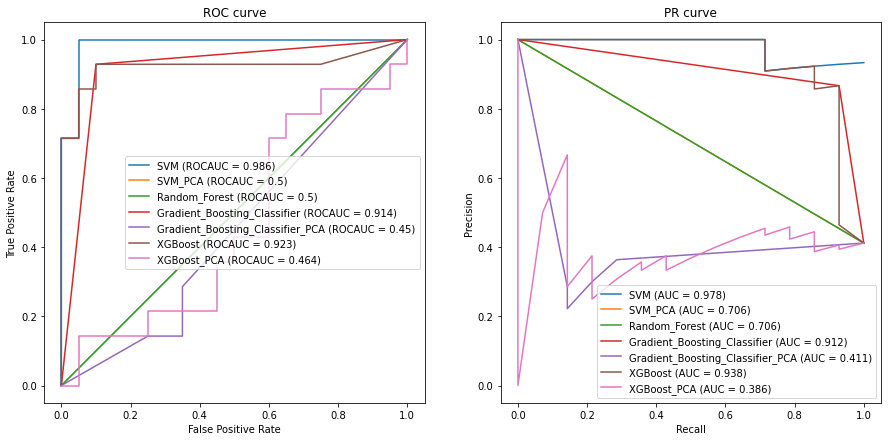

In [137]:
fig, (roc,pr) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 7))

#ROC
for clf in ROC_results.keys():
    roc.plot(ROC_results[clf][0], ROC_results[clf][1], label=f'{clf} (ROCAUC = {round(ROC_results[clf][2],3)})');

roc.set_xlabel('False Positive Rate')
roc.set_ylabel('True Positive Rate')
roc.set_title('ROC curve')
roc.legend();

#PR
for clf in PR_results.keys():
    pr.plot(PR_results[clf][1], PR_results[clf][0], label=f'{clf} (AUC = {round(PR_results[clf][2],3)})')

pr.set_xlabel('Recall')
pr.set_ylabel('Precision')
pr.set_title('PR curve')
pr.legend();
